In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# 加载数据
df = pd.read_csv('ratings.dat', sep='\t', names=['user', 'item', 'rating', 'timestamp'], header=None)
df = df.drop('timestamp', axis=1)

num_items = df.item.nunique()
num_users = df.user.nunique()

print("USERS: {} ITEMS: {}".format(num_users, num_items))

USERS: 6040 ITEMS: 3706


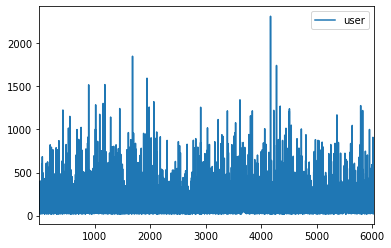

In [3]:
pd.DataFrame(df.user.value_counts().sort_index()).plot.line()

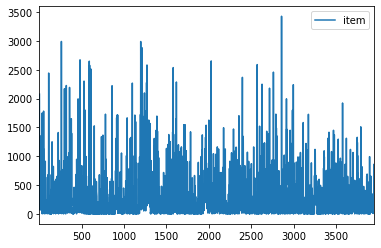

In [4]:
pd.DataFrame(df.item.value_counts().sort_index()).plot.line()

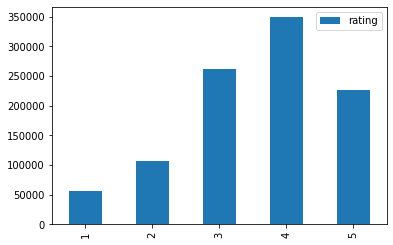

In [5]:
pd.DataFrame(df.rating.value_counts().sort_index()).plot.bar()

In [6]:
df.head()

,user,item,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [7]:
# 对输入做Normalization
from sklearn import preprocessing
r = df['rating'].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(r.reshape(-1,1))
df_normalized = pd.DataFrame(x_scaled)
df['rating'] = df_normalized
df

,user,item,rating
0,1,1193,1.00
1,1,661,0.50
2,1,914,0.50
3,1,3408,0.75
4,1,2355,1.00
5,1,1197,0.50
6,1,1287,1.00
7,1,2804,1.00
8,1,594,0.75
9,1,919,0.75


In [8]:
df.rating.values.astype(float)

array([1.  , 0.5 , 0.5 , ..., 1.  , 0.75, 0.75])

In [9]:
min_max_scaler.inverse_transform(df.rating.values.astype(float).reshape(-1,1))

array([[5.],
       [3.],
       [3.],
       ...,
       [5.],
       [4.],
       [4.]])

In [10]:
df.rating.value_counts()

0.75    348971
0.50    261197
1.00    226310
0.25    107557
0.00     56174
Name: rating, dtype: int64

In [11]:
# 把DataFrame转成user-item矩阵
matrix = df.pivot(index='user', columns='item', values='rating')
matrix.fillna(0, inplace=True)

In [12]:
users = matrix.index.tolist()
items = matrix.columns.tolist()
matrix = matrix.as_matrix()

In [13]:
matrix.shape

(6040, 3706)

In [14]:
matrix

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.5, 0. , 0. , ..., 0. , 0. , 0. ]])

In [15]:
# 网络超参数
num_input = num_items
num_hidden_1 = 10
num_hidden_2 = 5

X = tf.placeholder(tf.float64, [None, num_input])

# 隐层的变量初始化
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1], dtype=tf.float64)),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2], dtype=tf.float64)),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1], dtype=tf.float64)),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input], dtype=tf.float64)),
}

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2], dtype=tf.float64)),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'decoder_b2': tf.Variable(tf.random_normal([num_input], dtype=tf.float64)),
}

In [16]:
# 构建encoder
def encoder(x):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2


# 构建decoder
def decoder(x):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2


# 构建整个模型
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)


# 预测
y_pred = decoder_op


# 标准答案就是输入
y_true = X

In [107]:
# 定义损失函数和优化器，最小化square error
loss = tf.losses.mean_squared_error(y_true, y_pred)

#optimizer
# global_step = tf.Variable(0, trainable=False)
# learning_rate = tf.train.exponential_decay(.0001, global_step, 10000, 0.3, staircase=True)
optimizer = tf.train.RMSPropOptimizer(0.004).minimize(loss)
# optimizer = tf.train.AdadeltaOptimizer(0.01).minimize(loss)
# optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
# optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
# optimizer = tf.train.FtrlOptimizer(0.01).minimize(loss)
# optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

predictions = pd.DataFrame()

# 定义评估准则
eval_x = tf.placeholder(tf.int32, )
eval_y = tf.placeholder(tf.int32, )
pre, pre_op = tf.metrics.precision(labels=eval_x, predictions=eval_y)

In [108]:
# 变量初始化
init = tf.global_variables_initializer()
local_init = tf.local_variables_initializer()

In [109]:
# 在session中run
with tf.Session() as session:
    epochs = 100
    batch_size = 250

    session.run(init)
    session.run(local_init)

    num_batches = int(matrix.shape[0] / batch_size)
    matrix = np.array_split(matrix, num_batches)

    for i in range(epochs):

        avg_cost = 0

        for batch in matrix:
            _, l = session.run([optimizer, loss], feed_dict={X: batch})
            avg_cost += l

        avg_cost /= num_batches

        print("Epoch: {} Loss: {}".format(i + 1, avg_cost))

    print("Predictions...")

    matrix = np.concatenate(matrix, axis=0)

    preds = session.run(decoder_op, feed_dict={X: matrix})

    predictions = predictions.append(pd.DataFrame(preds))

    predictions = predictions.stack().reset_index(name='rating')
    predictions.columns = ['user', 'item', 'rating']
    predictions['user'] = predictions['user'].map(lambda value: users[value])
    predictions['item'] = predictions['item'].map(lambda value: items[value])

Epoch: 1 Loss: 239.78562100728354
Epoch: 2 Loss: 53.0384836991628
Epoch: 3 Loss: 19.62827742099762
Epoch: 4 Loss: 7.350272138913472
Epoch: 5 Loss: 2.6946886479854584
Epoch: 6 Loss: 1.158702549835046
Epoch: 7 Loss: 0.6531661959985892
Epoch: 8 Loss: 0.44530730446179706
Epoch: 9 Loss: 0.3381529673933983
Epoch: 10 Loss: 0.27327485506733257
Epoch: 11 Loss: 0.22774000838398933
Epoch: 12 Loss: 0.19193512325485548
Epoch: 13 Loss: 0.1622440858433644
Epoch: 14 Loss: 0.1373064536601305
Epoch: 15 Loss: 0.11623164359480143
Epoch: 16 Loss: 0.09828792947034042
Epoch: 17 Loss: 0.08300210411349933
Epoch: 18 Loss: 0.06982591034223636
Epoch: 19 Loss: 0.05768489604815841
Epoch: 20 Loss: 0.04429169092327356
Epoch: 21 Loss: 0.033658931187043585
Epoch: 22 Loss: 0.026579617445046704
Epoch: 23 Loss: 0.02353123971261084
Epoch: 24 Loss: 0.02216512228672703
Epoch: 25 Loss: 0.021543143937985103
Epoch: 26 Loss: 0.021243452404936154
Epoch: 27 Loss: 0.02112106637408336
Epoch: 28 Loss: 0.021050129396220047
Epoch: 29 L

In [110]:
# 为每个用户计算top10的推荐
print("Filtering out items in training set")
keys = ['user', 'item']
i1 = predictions.set_index(keys).index
i2 = df.set_index(keys).index

recs = predictions[~i1.isin(i2)]
recs = recs.sort_values(['user', 'rating'], ascending=[True, False])

#用户前十名评分
recs = recs.groupby('user').head(10)
# recs.to_csv('recs.tsv', sep='\t', index=False, header=False)

recs

Filtering out items in training set


,user,item,rating
802,1,858,0.446890
1212,1,1304,0.399392
1106,1,1196,0.372610
575,1,589,0.359505
1108,1,1198,0.325798
346,1,356,0.294491
843,1,904,0.284612
527,1,541,0.254078
1135,1,1225,0.241720
1059,1,1136,0.239207


In [138]:
recs["predict"]=recs.rating*5
recs[["user","item","predict"]]

,user,item,predict
802,1,858,2.234452
1212,1,1304,1.996962
1106,1,1196,1.863051
575,1,589,1.797523
1108,1,1198,1.628988
346,1,356,1.472457
843,1,904,1.423061
527,1,541,1.270392
1135,1,1225,1.208600
1059,1,1136,1.196034
